In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, 
                             precision_recall_curve, plot_precision_recall_curve, f1_score, average_precision_score, 
                             hinge_loss, precision_score, recall_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_breast_cancer, load_digits, fetch_openml, load_iris, make_moons, make_blobs
from sklearn.multiclass import OneVsRestClassifier
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
%matplotlib inline

### 1. Prezentacja o SVM

Link do prezentacji: https://1drv.ms/p/s!Ap19wJ6OUb8YgYMBlXjB0sOhyxqi0Q

### 2. Przykład działania SVM dla zbiorów WBC (WBreast cancer), MNIST, FMNIST - 500 elementów

In [32]:
# WBC
cancer = load_breast_cancer()

cancer_zipped = list(zip(cancer.data, cancer.target))
cancer_random_sample = random.sample(cancer_zipped, 500)
X, Y = zip(*(cancer_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

accuracy score: 0.98


In [33]:
# MNIST
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

mnist_zipped = list(zip(mnist.data, mnist.target))
mnist_random_sample = random.sample(mnist_zipped, 500)
X, Y = zip(*(mnist_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

accuracy score: 0.86


In [34]:
# FMNIST
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)

fmnist_zipped = list(zip(fmnist.data, fmnist.target))
fmnist_random_sample = random.sample(fmnist_zipped, 500)
X, Y = zip(*(fmnist_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

accuracy score: 0.8


In [35]:
# Porównianie kerneli dla powyższych zbiorów. 

In [36]:
def accuracy(dataset, kernel):
    dataset_zipped = list(zip(dataset.data, dataset.target))
    dataset_random_sample = random.sample(dataset_zipped, 500)
    X, Y = zip(*(dataset_random_sample))
    X = np.asarray(X)
    Y = np.asarray(Y)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

    clf = SVC(kernel='linear')
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    return accuracy_score(y_test,y_pred)

In [37]:
frame_data = []

for kernel in ('linear', 'poly', 'rbf'):
    frame_data.append([kernel, accuracy(cancer, kernel), accuracy(mnist, kernel), accuracy(fmnist, kernel)])

                  
frame = pd.DataFrame(frame_data, columns=["kernel", "cancer", "mnist", "fmnist"])
frame

,kernel,cancer,mnist,fmnist
0,linear,0.90,0.80,0.78
1,poly,0.92,0.96,0.86
2,rbf,0.94,0.84,0.74


### 3. Krótkie ćwiczenie dla studentów, w którym należy dobrać odpowiednie parametry kernela i uczenia dla wybranych zbiorów danych

In [38]:
# Just util functions. Imagine it's not here :)

data_colors = [(1, 0, 0), (0, 0, 1)]

def read_points_file(filename):
    pts = []
    with open(filename, "r") as f:
        for pt in f:
            pt = pt.strip("\n").split()
            pts.append([float(pt[0]), float(pt[1])])
    return pts


def read_data(class_0_file, class_1_file):
    pts_0 = read_points_file(class_0_file)
    pts_1 = read_points_file(class_1_file)

    x = pts_0 + pts_1
    labels = [0] * len(pts_0) + [1] * len(pts_1)
    x = np.array(x)
    return (x, labels)


def plot_data(X_train, y_train, X_test, y_test):

    X = np.concatenate((X_train, X_test))
    y = np.concatenate((y_train, y_test))

    colors = get_colors(y)
    colors_train = get_colors(y_train)
    colors_test = get_colors(y_test)


    plt.figure(figsize=(12, 4))

    # Plot all data plot
    plt.subplot(131)
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c = colors, s = 10, edgecolors=colors)
    plt.title("Data (100%)")

    # training data plot
    plt.subplot(132)
    plt.axis('equal')
    plt.scatter(X_train[:, 0], X_train[:, 1], c = colors_train, s = 10, edgecolors=colors_train)
    plt.title("Training Data (80%)")

    # testing data plot
    plt.subplot(133)
    plt.axis('equal')
    plt.scatter(X_test[:, 0], X_test[:, 1], c = colors_test, s = 10, edgecolors=colors_test)
    plt.title("Test Data (20%)")
    plt.tight_layout()

    plt.show()

    
def get_colors(y):
    return [data_colors[int(item)] for item in y]


def plot_decision_function(X_train, y_train, X_test, y_test, clf):
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.title("Training data")
    plot_decision_function_helper(X_train, y_train, clf)
    plt.subplot(122)
    plt.title("Test data")
    plot_decision_function_helper(X_test, y_test, clf, True)
    plt.show()


def plot_decision_function_helper(X, y, clf, show_only_decision_function = False):
    colors = get_colors(y)
    plt.axis('equal')
    plt.tight_layout()

    plt.scatter(X[:, 0], X[:, 1], c = colors, s = 10, edgecolors=colors)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    
def generate_train_set(X,Y):
    return train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state = 42)


def do_svm(train_X, test_X, train_Y, test_Y, plot=True, **kwargs):
    clf = SVC(**kwargs)
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(test_X)
    if plot:
        plot_decision_function(train_X, train_Y, test_X, test_Y, clf)
    print("Accuracy: " + str(accuracy_score(test_Y, y_pred)))

Zaobserwuj poniższy zbiór danych o dwóch cechach i w następnym kroku postaraj się wybrać odpowiednie parametry dla SVM

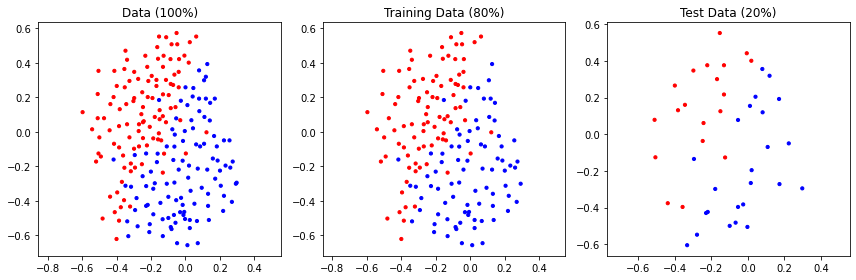

In [39]:
X, y = read_data("custom_datasets/1/points_class_0.txt", "custom_datasets/1/points_class_1.txt")
train_X, test_X, train_Y, test_Y = generate_train_set(X,y)
plot_data(train_X, train_Y, test_X, test_Y)

Wybierz dla powyższego zbioru odpowiednie parametry kernela oraz stałą uczenia, aby osiągnąć najlepszą dokładność. Wypróbuj wszystkie parametry, postaraj się zauważyć jak zmienia się wybrana hiperpłaszczyzna.

**Kernel** = wybierz jedno z: linear, poly, rbf, sigmoid

**C** = liczba rzeczywista

In [ ]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='?', C=?)

Zrób to samo co wcześniej, ale dla innego rodzaju danych

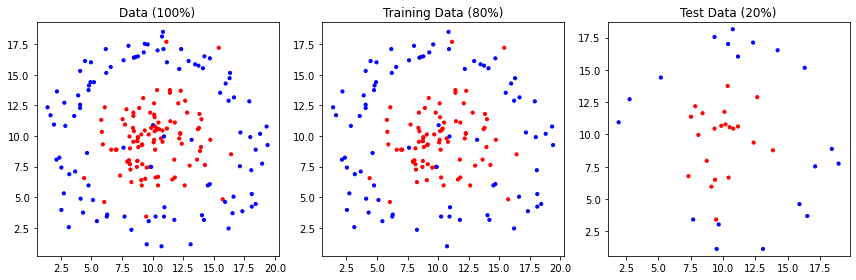

In [40]:
X, y = read_data("custom_datasets/2/points_class_0.txt", "custom_datasets/2/points_class_1.txt")
train_X, test_X, train_Y, test_Y = generate_train_set(X,y)
plot_data(train_X, train_Y, test_X, test_Y)

Wybierz dla powyższego zbioru odpowiednie parametry kernela oraz stałą uczenia, aby osiągnąć najlepszą dokładność.

In [ ]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='?', C=?)

Ostatni raz, zrób to samo co wcześniej, ale dla jeszcze innego rodzaju danych

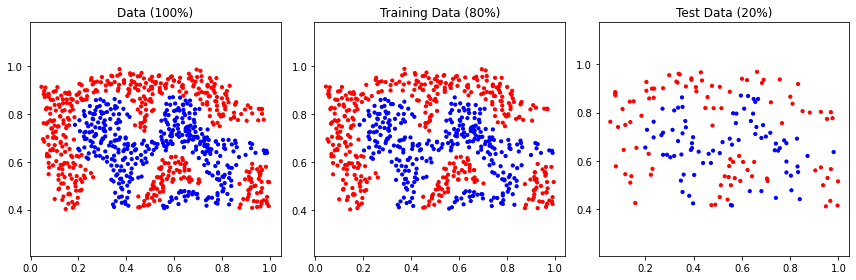

In [41]:
X, y = read_data("custom_datasets/3/points_class_0.txt", "custom_datasets/3/points_class_1.txt")
train_X, test_X, train_Y, test_Y = generate_train_set(X,y)
plot_data(train_X, train_Y, test_X, test_Y)

Wybierz dla powyższego zbioru odpowiednie parametry kernela oraz stałą uczenia, aby osiągnąć najlepszą dokładność.

In [ ]:
do_svm(train_X, test_X, train_Y, test_Y, kernel='?',C=?)

### 4. Omówienie accuracy, cross validation, loss, ROC curve, PR curve

Także w tej samej prezentacji: https://1drv.ms/p/s!Ap19wJ6OUb8YgYMBlXjB0sOhyxqi0Q

### 5. Wizualizacja accuracy, cross validation, loss, ROC curve, PR curve dla zbioru WBC

In [42]:
cancer = load_breast_cancer()

X, y = (cancer.data, cancer.target)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [43]:
# accuracy:
clf = SVC(kernel='linear', probability=True)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(f'accuracy = {accuracy_score(y_test,y_pred)}')

accuracy = 0.972027972027972


In [44]:
#cross validation
scores = cross_val_score(clf, X, y, cv=5)
print(f'cross validations scores:{scores}')

cross validations scores:[0.94736842 0.92982456 0.97368421 0.92105263 0.95575221]


In [45]:
#loss użyto funkcji hinge która jest stosowana w SVM
print(f'hinge function loss: {hinge_loss(y_test, y_pred)}')

hinge function loss: 0.38461538461538464


In [46]:
# precision score
print(f'precision score: {precision_score(y_test, y_pred)}')

precision score: 0.9680851063829787


In [47]:
# recall score
print(f'recall score: {recall_score(y_test, y_pred)}')

recall score: 0.9891304347826086


In [48]:
# f1 score
print(f'f1 score: {f1_score(y_test, y_pred)}')

f1 score: 0.9784946236559139


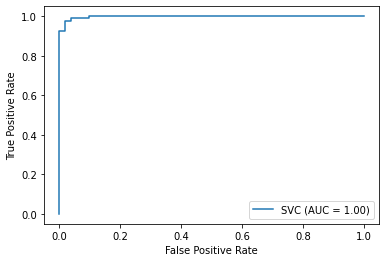

In [49]:
# ROC curve
# Binarize the output
svc_disp = plot_roc_curve(clf, x_test, y_test)
plt.show()

Average precision score, micro-averaged over all classes: 0.96


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.96')

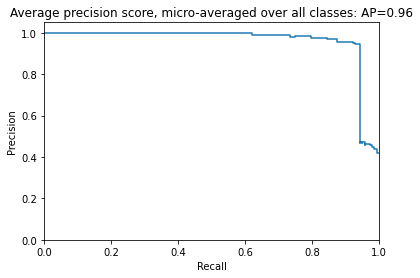

In [50]:
# PR_curve
y_binarized = label_binarize(y, classes=[0, 1, 2])
n_classes = y_binarized.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, y_binarized, train_size=0.75)

# Run classifier
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True))
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

### 5. Zadania

a. Na zbiorach MNIST, FMNIST, TNG (twenty news groups) zaprezentować działanie
klasyfikatora SVM i wyniki porównać do klasyfikatora k-NN przy pomocy poznanych miar
walidacji klasyfikacji. (dla najlepszej konfiguracji, stałej uczenia, funkcji kernela)

In [ ]:
# todo

b. Zaproponować, taką augmentację zbiorów treningowych (wielkość zbioru zależna od
mocy obliczeniowej którą Państwo dysponują) aby uzyskać jak najlepsze miary jakości na
zbiorach testowych.

In [ ]:
# todo